# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.258637,True,2.405568
1,-1.410309,False,-3.276105
2,0.373648,False,0.745694
3,-0.890784,True,2.459542
4,-1.709225,False,-3.169654
...,...,...,...
995,0.556842,True,5.359667
996,0.197870,False,-0.683598
997,-2.014307,False,-3.209927
998,1.054081,False,1.914296


<AxesSubplot: xlabel='v0'>

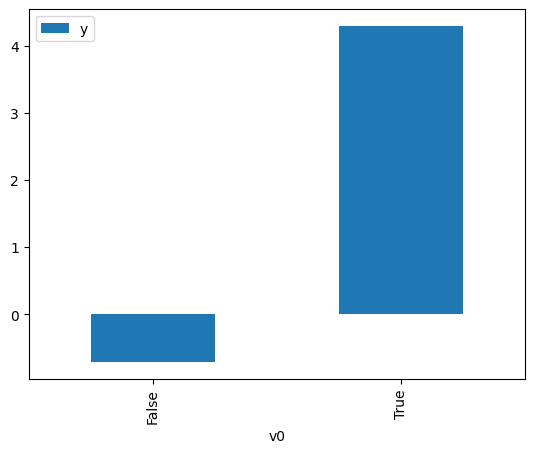

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

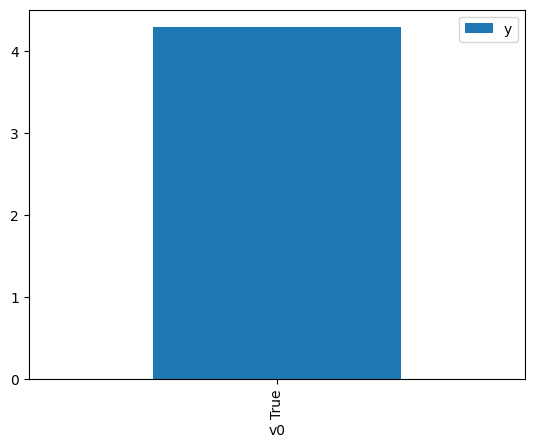

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.594207,False,-2.790014,0.765102,1.307015
1,0.408457,False,-0.184075,0.406721,2.458688
2,-1.413526,False,-2.396976,0.738900,1.353363
3,-1.028396,False,-2.326481,0.677120,1.476844
4,0.195549,False,0.844234,0.447232,2.235976
...,...,...,...,...,...
995,1.623951,False,1.936535,0.210255,4.756122
996,0.069743,False,0.662607,0.471540,2.120711
997,-0.485615,False,-0.372054,0.578884,1.727461
998,-0.110329,False,1.154404,0.506540,1.974178


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.226035,True,5.671544,0.558625,1.790110
1,-1.187694,True,4.186240,0.296395,3.373878
2,-1.906061,True,3.223932,0.194109,5.151752
3,0.294511,True,5.775278,0.571719,1.749110
4,0.310934,True,4.267306,0.574845,1.739598
...,...,...,...,...,...
995,-1.579779,True,3.511541,0.236922,4.220802
996,0.466419,True,5.149593,0.604115,1.655314
997,-0.697253,True,4.556066,0.381572,2.620740
998,-0.826116,True,2.889539,0.358206,2.791689


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              6538.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:58:48   Log-Likelihood:                         -1415.8
No. Observations:                1000   AIC:                                      2836.
Df Residuals:                     998   BIC:                                      2845.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4638      0.029     50.726      0.000       1.407       1.520
x2             4.9404      0.048    103.820      0.000       4.847       5.034
==============================================================================
Omnibus:                        3.756   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.618
Skew:                          -0.140   Prob(JB):                        0.164
Kurtosis:                       3.091   Cond. No.                         1.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""